In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Shapley Value when applied to ML model.

## Motivation

In the context of a coalitional game, a group of players ($\mathcal{N}$) form a coalition to play the game and obtain a payoff (aka. credit) $v(\mathcal{N})$, where is $v$ is a function that maps a set of players to a real value, $v: 2^N \rightarrow \mathbb{R}$. 

$v$ is called a value function or a worth function. 

Note, $v(\emptyset)$ may not be zero.

The question is how to divide payoff among all the $N$ players fairly, where $N = |\mathcal{N}|$?

There can be multiple definitions for fairness. One way to define it is come up with a few properties that match our intuitions for what a fair division of the payoff should be like and then see what solutions we have that would satisfy these properties. 

## Fairness properties

We'll use $\phi_i(\mathcal{N}, v)$ to denote the amount of credit allocated to player $i$.

Each properties may have multiple names, we will use the conventions from [A Course in Game Theory by Martin J. Osborne  and Ariel Rubinstein](https://www.amazon.com/Course-Game-Theory-MIT-Press/dp/0262650401).

#### Efficiency (Local accuracy/completeness)

The sum of allocations to all players should sum up to $v(\mathcal{N}) - v(\emptyset)$. In the context of game theory,  may be assumed to be $v(\emptyset) = 0$ as when no one plays a game, it's understandable to assume no payoff. But this will often not be the case when Shapley value is applied to machine learning models, so we'll be explicit with $v(\emptyset)$ when describing the fairness properties.

$$
\sum_i^{N} \phi_i(\mathcal{N}, v) = v(\mathcal{N})
$$

#### Symmetry (Symmetry-preserving)

If player $i$ and $j$ are identical in how much they can contribute to the payoff when either of them join an existing coalition ($\mathcal{S}$), then they should get the same amount of credit.

If

$$
v(\mathcal{S} \cup \{i\}) = v(\mathcal{S} \cup \{j\})
$$

 for all $\mathcal{S}$, then 

$$\phi_i(\mathcal{N}, v) = \phi_j(\mathcal{N}, v)$$

#### Dummy player (Null effects/Sensitivity)

<span style="color:red">what's the diff between Null effects and missingness? (the latter appears to be about when a feature is not in $x_\mathcal{S}$, then $\phi_i(\mathcal{N}, v) = 0$, which does seem trivial.</span>

If the joining of player doesn't change the payoff at all, this player gets no credit.

If

$$
v(\mathcal{S} \cup \{i\}) = 0
$$

for all $\mathcal{S}$, then 

$$
\phi_i(\mathcal{N}, v) = 0
$$

#### Additivity (Linearity)

If $v$ can be divided into two games, $v$ and $w$, then

$$
\phi_i(\mathcal{N}, v + w) = \phi_i(\mathcal{N}, v) + \phi_i(\mathcal{N}, w)
$$

It's harder to motivate this property, but mathematically convenient (by a course on game thoery, Page 293).

In  <div class="csl-entry">Young, H. P. (1985). Monotonic solutions of cooperative games. <i>International Journal of Game Theory</i>, <i>14</i>(2), 65–72. https://doi.org/10.1007/BF01769885</div>,

The monotonicity axiom, which Shapley Value also satisifies, implies Dummy player and Additivity axioms.

##### Monotonicity

If player in increase the payoff more in game v than in game w for all $\mathcal{S}$, then its credit in v should be more than in game w.

If

$$
v(\mathcal{S} \cup \{i\}) - v(\mathcal{S}) \ge w(\mathcal{S} \cup \{i\}) - w(\mathcal{S})
$$

for all $\mathcal{S}$, then

$$
\phi_i(\mathcal{N}, v) \ge \phi_i(\mathcal{N}, w)
$$

In <div class="csl-entry">Lundberg, S. M., &#38; Lee, S. I. (2017). A unified approach to interpreting model predictions. <i>Advances in Neural Information Processing Systems</i>, <i>2017-Decem</i>(Section 2), 4766–4775.</div> (supplemental), it further shows that monotonicity (aka. consistency) axiom also implies symmetry.


Therefore, the above four axioms become just two: **efficiency** and **monotonicity**. In Lundberg's paper, he also added a trivial property called missingness as a constraint to make an optimization problem have a unique solution (https://github.com/slundberg/shap/issues/175#issuecomment-407134438).

## Shapley Value

It turns out that using these properties as constraints, there is a unique solution for $\phi_i$, called the Shapley value, which is defined as 

\begin{align*}
\phi_i(N, v) = \frac{1}{|N|!} \sum_{P \in \mathcal{P}} v ( P[:d_i+1] ) - v( P[:d_i] )
\end{align*}

where

* $N$ is the set of players
* $v$ is a value function that maps a set of players to a real number, $v: \text{Power Set}(N) \rightarrow \mathbb{R}$.
* $\phi_i(N, v)$ is the allocated credit for player $i$.
* $\mathcal{P}$ is the set of all permutations of the players.
* $P$ is one of the permutations.
* $d_i$ is the index of player $i$ in permutation $P$.
* $P[:d_i]$ is the set of all palyers before $i$ without $i$.
* $P[:d_i+1]$ is the set of all players before $i$ and $i$.


So Shapley value can be interpreted as the average marginal contribution from player $i$ over all permutations.

Let $S$ be the set of players in $P[:d]$, and $S \cup \{i\}$ be the set of players in $P[:d + 1]$. So $v(S) = v(P[:d])$ and $v(S \cup \{i\}) = v(P[: d + 1])$ Note, $P$ is ordered while $S$ is not.

Notice that once $S$ is fixed, the ordering of the players in $S$ does not affect $v(S)$, and there are $s!$ ways of ordering them (aka. permutations). Similarly, the ordering of the players after $i$ does not matter either, and there are $(n - s - 1)!$ ways of ordering. Therefore, Shapley value can also be written in a more common form,

\begin{align*}
\phi_i(N, v)
&= \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \Big[v(S \cup \{i\}) - v(S) \Big] \\
&= \sum _{S \subseteq N \backslash \{i\}} w(S, N) \Big[v(S \cup \{i\}) - v(S) \Big] \\
\end{align*}

\begin{align*}
\phi_i(N, v)
&= \sum _{S \subseteq N \backslash \{i\}} w(S, N) \Big[v(S \cup \{i\}) - v(S) \Big] \\
\end{align*}

In this form, the Shapley value is interpreted as the weighted average of marginal contributions from $i$ over all possible subsets of players before $i$. The weight is calculated $\frac{s!(n - s - 1)!}{n!}$.

A third form of writing Shapley value is from directly transforming the factorials into combinatorial notation,

\begin{align*}
\phi_i(N, v)
&= \sum _{S \subseteq N \backslash \{i\}} \frac{s!(n - s - 1)!}{n!} \Big(v(S \cup \{i\}) - v(S) \Big) \\
&= \frac{1}{n} \sum _{S \subseteq N \backslash \{i\}} \frac{s!(n - s - 1)!}{(n - 1)!} \Big(v(S \cup \{i\}) - v(S) \Big) \\
&= \frac{1}{n} \sum _{S \subseteq N \backslash \{i\}} \binom{n - 1}{s}^{-1} \Big(v(S \cup \{i\}) - v(S) \Big) \\
&= \frac{1}{n} \sum_{t = 0}^{n - 1} \binom{n - 1}{t}^{-1} \sum _{S \subseteq N \backslash \{i\} \\ s.t. |S| = t} \Big(v(S \cup \{i\}) - v(S) \Big) \\
\end{align*}

Note,

* In the 3rd equality, $\binom{n - 1}{s}$ is the number of ways to pick $s$ out of $n$ players without player $i$, so we can group the summands by possible $s$ values in the 4th equality, which ranges from $0$ to $n - 1$ (pick all players but $i$). 

We used $t$ instead of $s$ in the 4th equality to avoid confusion because by definition $s$ is always equal to $|S|$. More specifically, the difference between the last two equalities is that in Equality 3, we pick $S$ first, and then calculate its size $s$, while in Equality 4, we determine the size of the $S$ to pick first and then pick $S$ of only that size.

A more common formulation of Shapley value (with straightforward derviation) is like 

\begin{align*}
\phi_i(N, v)
&= \sum _{S \subseteq N \backslash \{i\}} \frac{s!(n - s - 1)!}{n!} \Big(v(S \cup \{i\}) - v(S) \Big) \\
&= \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \Big(v(S \cup \{i\}) - v(S) \Big) \\
\end{align*}

## SHAP

SHAP stands for SHapley Additive exPlanations, it basically means the application of Shapley value to ML models.

When applying Shapley value to machine learning, it's tempting to consider the features as the set of players and the ML model $f$ as the value function $v$. But that's not correct because $v$ can take any subset of the players, while $f$ must take all features to evaluate the outcome. Specifically,

* $v: \text{power set}(N) \rightarrow \mathbb{R}$
* $f: \mathbb{R}^{|N|} \rightarrow \mathbb{R}$, $|N|$ is the feature space dimension

Suppose only features from a subset of all features $x_\mathcal{S}$ is available, an intuitive yet reasonable idea is to sample the rest of the features $X_\overline{\mathcal{S}}$ (use upper case to indicate it's a random variable) to make up a full feature vector so that we can call $f$, which we write as


$$
f(x_S, X_{\overline{S}})
$$

$f(x_S, X_{\overline{S}})$, where $X_{\overline{S}}$ is an r.v.

where 

* $X_{\overline{S}}$ is a random variable.

and then take its expectation.

Two questions:

* $p(X_\overline{S})$ v.s. $p(X_{\overline{S}} | X_{S} = x_{S})$
* 
* $f\left(x_S, \mathbb{E}\left[X_{\overline{S}}\right]\right)$ v.s. $\mathbb{E}\left[f\left(x_S, X_{\overline{S}}\right)\right]$


But we're still left with the problem of how to sample $X_\overline{\mathcal{S}}$, there is debate around whether it should be sampled from 

* the marginal distribution $p(X_\overline{\mathcal{S}})$ or 
* the conditional distribution $p(X_{\overline{\mathcal{S}}} | X_{\mathcal{S}} = x_{\mathcal{S}})$

From the perspective of causal analysis (<div class="csl-entry">Janzing, D., Minorics, L., &#38; Blöbaum, P. (2019). Feature relevance quantification in explainable ai: A causal problem. <i>ArXiv</i>, <i>2015</i>. http://arxiv.org/abs/1910.13413</div>), the first distribution is preferred, which is also the one simpler to calculate, while it's been found that the second one has implication in <span style="color:red">violating Dummy player property (STILL NOT fully unerstanding why exactly)</span>.

https://hughchen.github.io/its_blog/index.html#shapley_value_ex

>1.) ICE Shapley values are tractable to compute as opposed to CE Shapley values that require modelling many conditional expectations and 2.) ICE Shapley values more explicitly describe the model’s behavior whereas CE Shapley values conflate the model’s behavior with the correlation in the data.

Therefore, we have 

\begin{align*}
v(S) 
&= \mathbb{E}[f(\mathbf{x}_S, \mathbf{X}_{\overline{S}})] \\
&= \int f(\mathbf{x}_S, \mathbf{x}_{\overline{S}}) p(\mathbf{X}_{\overline{S}} = \mathbf{x}_{\overline{S}}) d\mathbf{X}_{\overline{S}} \\
\end{align*}

More interpretation.

\begin{align*}
v(S) 
&= \int f(x_S, x_{\overline{S}}) p(X_{\overline{S}} = x_{\overline{S}}) dX_{\overline{S}} \\
\end{align*}

\begin{align*}
v(S) 
&= \mathbb{E}[f(x_S, X_{\overline{S}})] \\
&= \int f(x_S, x_{\overline{S}}) p(X_{\overline{S}} = x_{\overline{S}}) dX_{\overline{S}} \\
&= \sum_{x' \in \mathcal{D}} f(x_S, x'_{\overline{S}}) \\
&= \int \mathbb{E}[Y|x_S, x_{\overline{S}}] p(X_{\overline{S}} = x_{\overline{S}}) dX_{\overline{S}} \\
&= \mathbb{E}[Y|do(X_{\overline{S}} = x_{\overline{S}})]
\end{align*}

Then we can use use $v(\mathcal{S}, f)$ in the Shapley value formula and calculate Shapley value for each feature accordingly.

Note in the special case when $S = \emptyset$,

\begin{align*}
v(\emptyset) 
&= \mathbb{E}[f(\mathbf{X})] \\
&= \int f(\mathbf{x}) p(\mathbf{X} = \mathbf{x}) d\mathbf{x}
\end{align*}


i.e. the average model prediction over the whole feaure space.

Plug in this definition of $v(\mathcal{S})$ into the definition of Shapley value,

\begin{align*}
\phi_i(N, v)
&= \sum_{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \Big[v(S \cup \{i\}) - v(S) \Big] \\
&= \sum_{S \subseteq N \backslash \{i\}} w(S, N) \Big[v(S \cup \{i\}) - v(S) \Big] \\
&= \sum_{S \subseteq N \backslash \{i\}} w(S, N) \left[ \frac{1}{|\mathcal{D}|} \sum_{ \mathbf{x} \in \mathcal{D}} f(\mathbf{x}^*_{S \cup \{i\}}, \mathbf{x}_{\overline{S \cup \{i\}}}) - f(\mathbf{x}^*_{S}, \mathbf{x}_{\overline{S}})) \right] \\
&= \frac{1}{|\mathcal{D}|} \sum_{ \mathbf{x} \in \mathcal{D}} \sum_{S \subseteq N \backslash \{i\}} w(S, N) \left[ f(\mathbf{x}^*_{S \cup \{i\}}, \mathbf{x}_{\overline{S \cup \{i\}}}) - f(\mathbf{x}^*_{S}, \mathbf{x}_{\overline{S}})) \right] \\
&= \frac{1}{|\mathcal{D}|} \sum_{ \mathbf{x} \in \mathcal{D}} \psi_i(N, f, \mathbf{x}^*, \mathbf{x, S})
\end{align*}

$\mathbf{x}^*$ is the example, whose explanation is to be explained.

TreeShap finds a **polynomial algorithm** for evaluating $\sum_{\mathcal{S} \subseteq \mathcal{N} \backslash \{i\}} w(\mathcal{S}, \mathcal{N}) \left[ f(\mathbf{x}^*_{\mathcal{S} \cup \{i\}}, \mathbf{x}_{\overline{\mathcal{S} \cup \{i\}}}) - f(\mathbf{x}^*_{\mathcal{S}}, \mathbf{x}_{\overline{\mathcal{S}}})) \right]$ for a single $\mathbf{x}$. This is identical to the Baseline Shapley value.

The key idea is to consider each path in a tree as itself a model, then calculate Shapley value for each path model, and sum them up, which removes the exponential term in the complexity from $\mathcal{S} \subseteq  \mathcal{N}\backslash \{i\}$. Further, using a dynamic programming, attributes of all features can be evaluated simultaneously, which results in a computational complexity of 

$O(\# trees \times \# nodes)$.

In **TreeExplainer with path-dependent feature perturnbation**, $v(\mathcal{S})$ is estimated based on how many training data points falls into the subtree corresponds to each node in the tree, and then somehow turned into a polynomial algorithm.

In **TreeExplainer with interentional feature perturbation**, it focused on the optimization of the calculation of $\psi_i(\mathcal{N}, f, \mathbf{x}^*, \mathbf{x, \mathcal{S}})$ and make it polynomial.

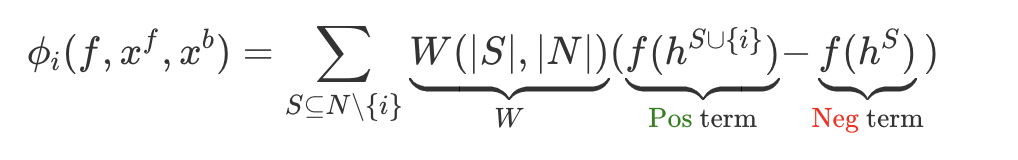

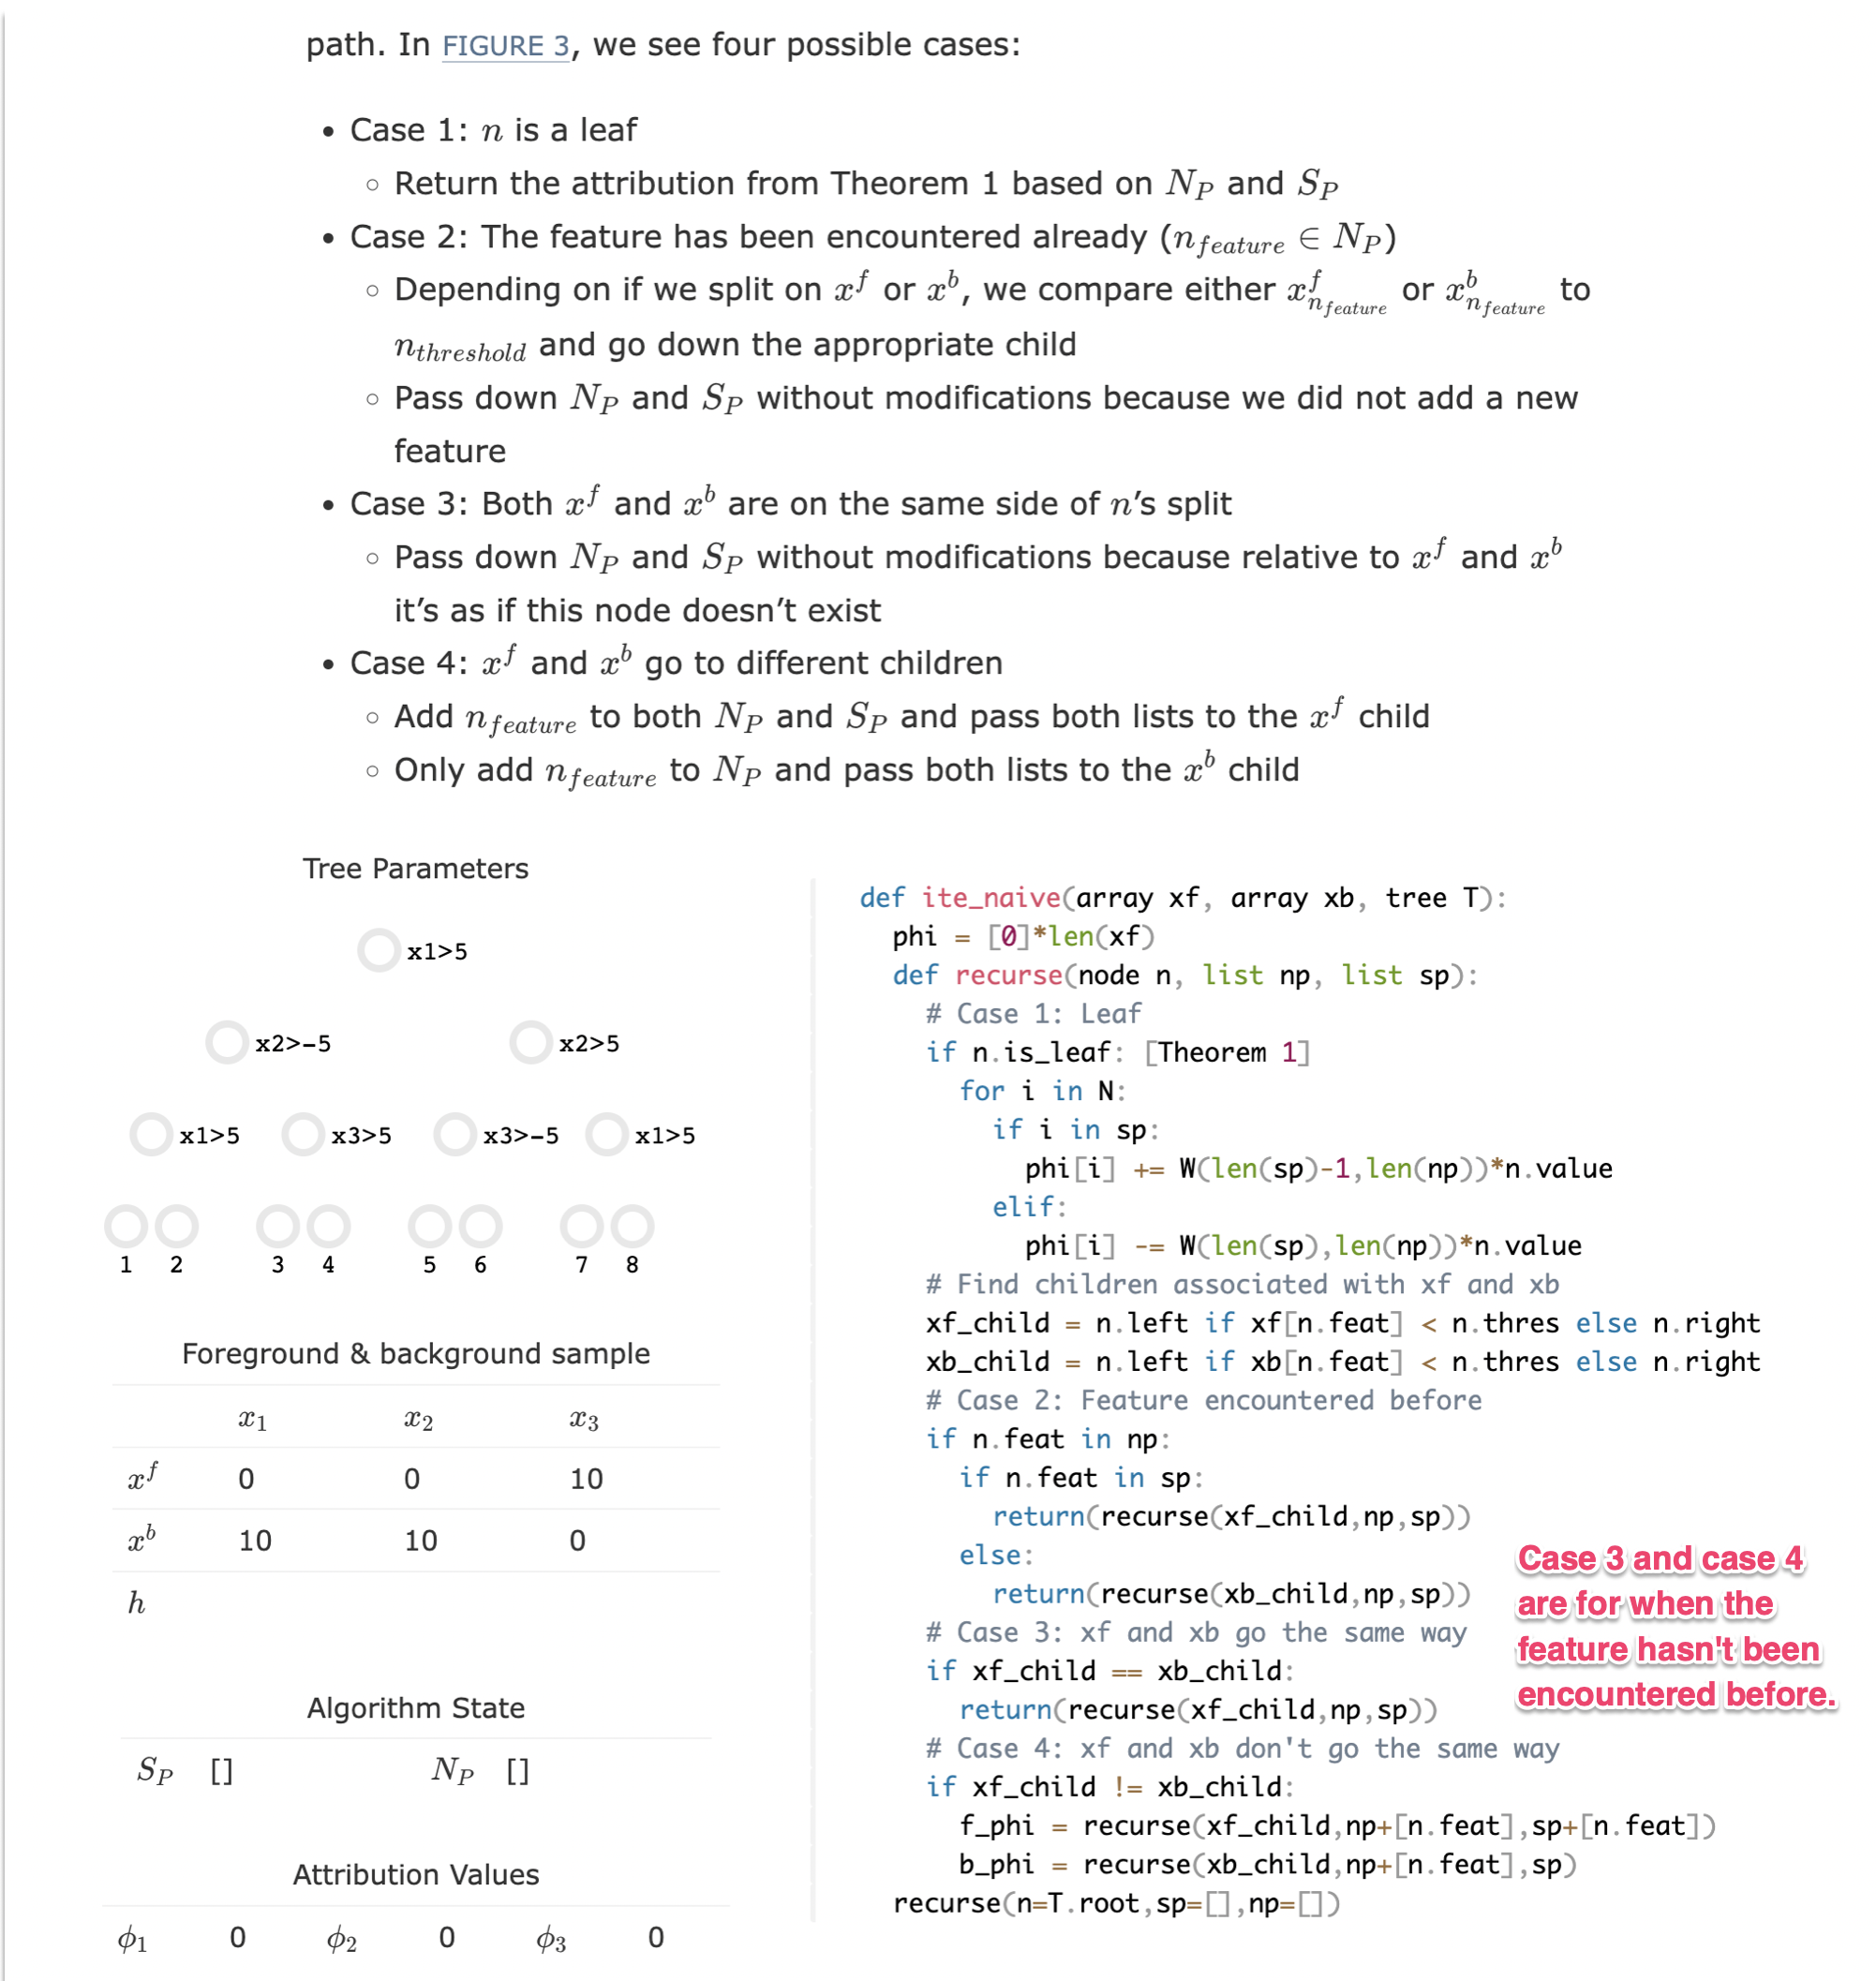

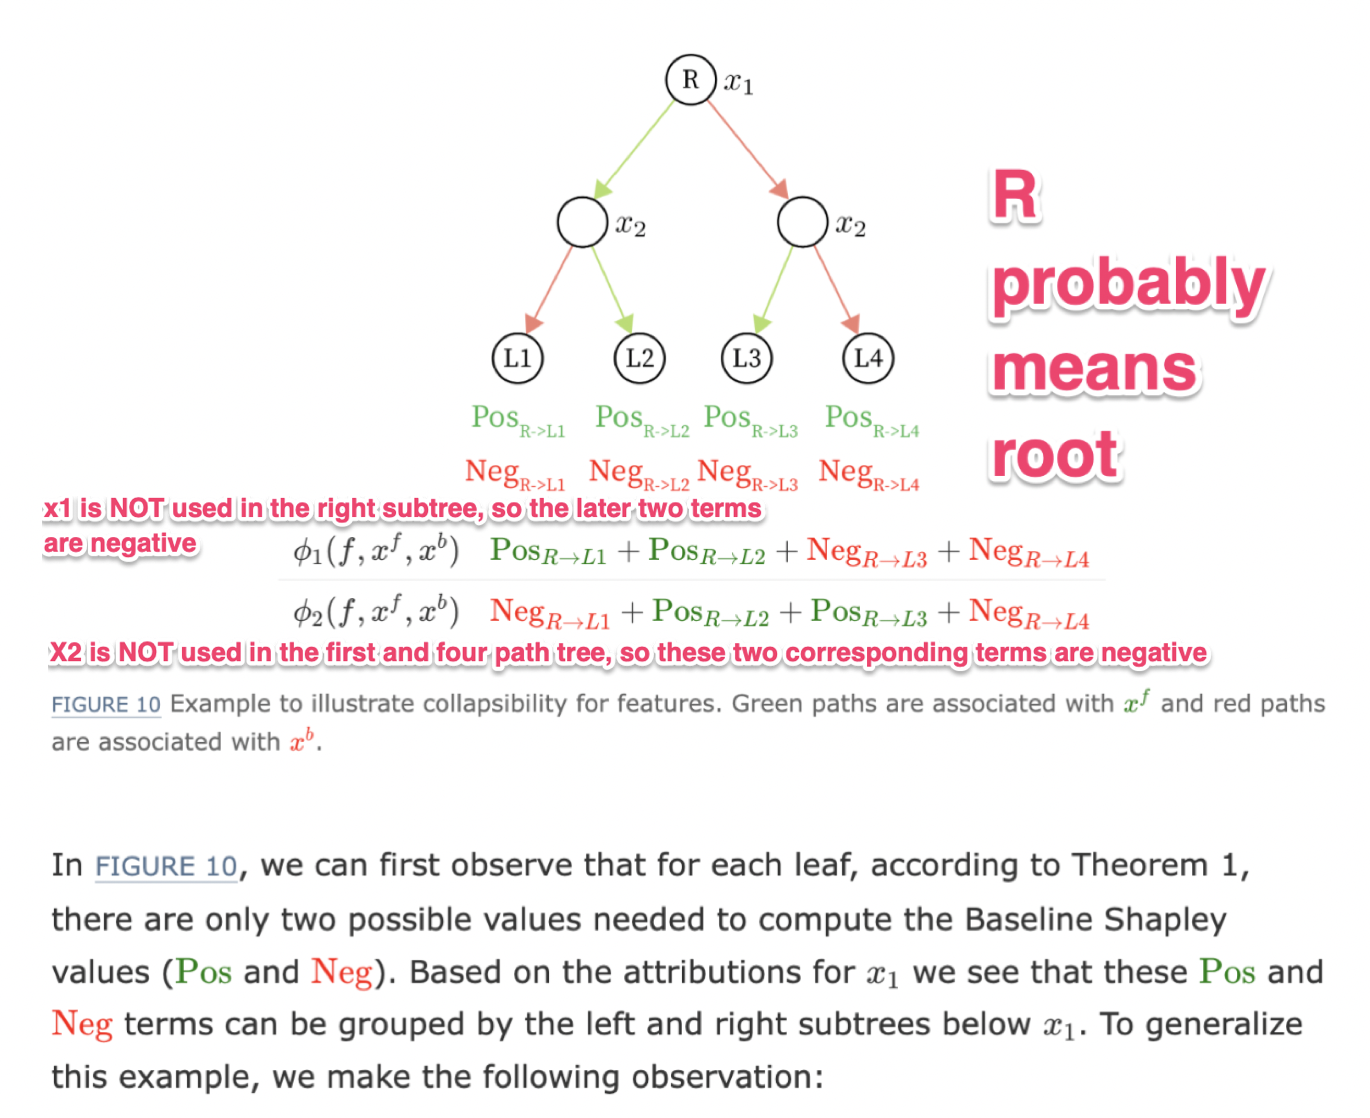

* <div class="csl-entry">Lundberg, S. M., &#38; Lee, S. I. (2017). A unified approach to interpreting model predictions. <i>Advances in Neural Information Processing Systems</i>, <i>2017-Decem</i>(Section 2), 4766–4775.</div>

* <div class="csl-entry">Janzing, D., Minorics, L., &#38; Blöbaum, P. (2019). Feature relevance quantification in explainable ai: A causal problem. <i>ArXiv</i>, <i>2015</i>. http://arxiv.org/abs/1910.13413</div>

# TODO

* Symbol unification:
  * use Upper case letters (N, S, P) for set, except that X means a random variable.
  * use $\mathbf{x}$ (bold) for vector.
  * use $X$ (upper) for random variable vector.
  * use $\mathbf{x}^*$ for the example to be explained.

# FastTreeShap notes.

### Rederive Theorem 1

The Algorithm 1 from the original TreeShap paper for estimating $v(S) = \mathbb{E}[f(x_S, x_{\overline{S}})]$ can be written as 

\begin{align*}
v(S) 
&= f_S(x) \\
&= \sum_{k=1}^K {\color{Red}{ \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \notin S} R_{kj} }} v_k \\
&= \sum_{k=1}^K {\color{Red}{ W_{k, S} }} v_k
\end{align*}

(It's pretty amazing an algorithm can be summarized by one function)

where

* $k$ is the index of a path in the tree
* $P_k$ is a particular path, i.e. a set of nodes along path $k$.
* $j$ is a node index in the path
* $d_j$ is the splitting feature in node j.
* $R_{kj}$ is the coverage ratio
* $v_k$ is the value of the leaf node in path $k$.

The red part is the so-called proportion of subset S that flows down into the leaf node $v_k$.

Therefore, the Shapley value can be calculated as

\begin{align}
\phi_i(N, v)
&= \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!}  \Big[v(S \cup \{i\}) - v(S) \Big] \\
&= \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!}  \left[ \sum_{k=1}^K  W_{k, S \cup \{i\}} v_k - \sum_{k=1}^K  W_{k, S} v_k \right ] \\
&= \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!}  \left[ \sum_{k=1}^K  \left( W_{k, S \cup \{i\}} - W_{k, S} \right) v_k \right] \\
&= \sum_{k=1}^K \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right) v_k  \\
&= \sum_{k=1, i \in D_k}^K \sum _{S \subseteq N \backslash \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right) v_k  \\
\end{align}

Note

* the 5th equality is because for a path $k$ with the corresponding splitting feature set $D_k$, if feature $i \notin D_k$, then $W_{k, S \cup \{i\}} = W_{k, S}$ as $d_j \in S \cup \{i\} \Leftrightarrow d_j \in S$ for all $d_j \in D_k$.

Similarly, $\forall l \notin D_k$ and $l \neq i$,

\begin{align*}
W_{k, S \cup \{i, l \}} &= W_{k, S \cup \{i\}} \\
W_{k, S \cup \{l\}} &= W_{k, S} \\
\end{align*}

Therefore,

\begin{align*}
W_{k, S \cup \{i, l \}} - W_{k, S \cup \{l\}} 
&= W_{k, S \cup \{i\}} - W_{k, S} \\
\end{align*}

Then, $\phi_i(N, v)$ can be decomposed into two parts

\begin{align*}
\phi_i(N, v)
&= \sum_{k=1, i \in D_k}^K \left[ \sum _{S \subseteq N \backslash \{i, l \}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right) + \sum _{S \subseteq N \backslash \{i, l \}} \frac{(|S| + 1)!(|N| - |S| - 2)!}{|N|!} \left( W_{k, S \cup \{i, l\}} - W_{k, S \cup \{l\}} \right) \right ] v_k \\
&= \sum_{k=1, i \in D_k}^K \left[ \sum _{S \subseteq N \backslash \{i, l \}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right) + \sum _{S \subseteq N \backslash \{i, l \}} \frac{(|S| + 1)!(|N| - |S| - 2)!}{|N|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right) \right ] v_k \\
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq N \backslash \{i, l \}} \left( \frac{|S|!(|N| - |S| - 1)!}{|N|!} +  \frac{(|S| + 1)!(|N| - |S| - 2)!}{|N|!} \right )\left( W_{k, S \cup \{i\}} - W_{k, S} \right)  v_k \\
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq N \backslash \{i, l \}} \frac{|S|!(|N| - |S| - 2)!}{(|N| - 1)!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right)  v_k \\
\end{align*}

* The first term does NOT have $l$ in the subset $S$ and
* the second term adds $l$ to $S$.

If we remove all $l$ from $N$, the above equality still holds, so

\begin{align*}
\phi_i(N, v)
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{|S|!(|D_k| - |S| - 1)!}{|D_k|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right)  v_k \\
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{|S|!(|D_k| - |S| - 1)!}{|D_k|!} \left( W_{k, S \cup \{i\}} - W_{k, S} \right)  v_k \\
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{|S|!(|D_k| - |S| - 1)!}{|D_k|!} \left[ \prod_{j \in P_k, d_j \in S \cup \{i\}} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \notin S \cup \{i\}} R_{kj} - \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \notin S} R_{kj} \right ] v_k \\
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{|S|!(|D_k| - |S| - 1)!}{|D_k|!} \left[ \prod_{j \in P_k, d_j \in S \cup \{i\}} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash(S \cup \{i\})} R_{kj} - \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash S} R_{kj} \right ] v_k
\end{align*}

Note, given $ S \subseteq D_k \backslash \{i\}$, $d_j \notin S$ is equivalent to $d_j \in D_k \backslash S$. Similarly, $d_j \notin S \cup \{i\}$ is equivalent to $d_j \in D_k \backslash (S \cup \{i\})$.

Using distributive rule, we can factor out the common factor 

$$
\prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash(S \cup \{i\})} R_{kj}
$$

so, $\phi_i(N, v)$ becomes

\begin{align*}
\phi_i(N, v) &= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{|S|!(|D_k| - |S| - 1)!}{|D_k|!}  \left[ \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash(S \cup \{i\})} R_{kj} \left( \prod_{j \in P_k, d_j = i} \mathbb{1} ({x_{d_j} \in T_{kj}}) - \prod_{j \in P_k, d_j =i} R_{kj} \right ) \right ] v_k
\end{align*}

let $m = |S|$, then

\begin{align*}
\phi_i(N, v)
&= \sum_{k=1, i \in D_k}^K  \sum _{S \subseteq D_k \backslash \{i \}} \frac{m!(|D_k| - m - 1)!}{|D_k|!}  \left[ \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash(S \cup \{i\})} R_{kj} \left( \prod_{j \in P_k, d_j = i} \mathbb{1} ({x_{d_j} \in T_{kj}}) - \prod_{j \in P_k, d_j =i} R_{kj} \right ) \right ] v_k \\
&= \sum_{k=1, i \in D_k}^K \sum_{m=0}^{|D_k| - 1} \frac{m!(|D_k| - m - 1)!}{|D_k|!} \sum _{S \subseteq D_k \backslash \{i \}, |S|=m} \left[ \prod_{j \in P_k, d_j \in S} \mathbb{1} ({x_{d_j} \in T_{kj}}) \prod_{j \in P_k, d_j \in D_k \backslash(S \cup \{i\})} R_{kj} \left( \prod_{j \in P_k, d_j = i} \mathbb{1} ({x_{d_j} \in T_{kj}}) - \prod_{j \in P_k, d_j =i} R_{kj} \right ) \right ] v_k
\end{align*}

In [21]:
def factorial(n):
    out = 1
    for i in range(1, n + 1):
        out *= i
    return out

In [51]:
def sum1(n, s):
    f = factorial
    p1 = f(s) * f(n - s - 1) / f(n)
    p2 = f(s + 1) * f(n - s) / f(n)
    print(f'{p1=:}')
    print(f'{p2=:}')
    return p1 + p2

In [52]:
def sum2(n, s):
    f = factorial
    return f(s) * f(n - s - 2) / f(n - 1)

In [53]:
N = 3
S = 1

In [54]:
sum1(N, S)

p1=0.16666666666666666
p2=0.6666666666666666


0.8333333333333333

In [55]:
5/6

0.8333333333333334

In [39]:
sum2(N, S)

0.5

In [6]:
import sympy

In [7]:
s, n = sympy.symbols('s, n')

In [16]:
out2 = (n - s - 1) * (1 + (s + 1) * (n - s))

In [17]:
out2.expand()

n**2*s + n**2 - 2*n*s**2 - 3*n*s + s**3 + 2*s**2 - 1

In [13]:
out = (n - s - 1) + (n - s - 1) * (s + 1) * (n - s)

In [15]:
out.expand()

n**2*s + n**2 - 2*n*s**2 - 3*n*s + s**3 + 2*s**2 - 1